# Module 6 Assignment

In this final assignment of the course, you'll use deep learning to count people in a dataset of images.

You'll use skills learned throughout the course to select, use and interpret the outputs of a pre-trained model that's suited to the task.

### 0) Setup

In [1]:
import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
import gluoncv as gcv
import hashlib
from pylab import rcParams
from matplotlib import pyplot as plt
from gluoncv import model_zoo, data, utils
import numpy as np
import os
from pathlib import Path

rcParams['figure.figsize'] = 5, 10

In [2]:
M6_DATA = Path(os.getenv('DATA_DIR', '../../data'), 'module_6')
M6_IMAGES = Path(M6_DATA, 'images')
M6_MODELS = Path(M6_DATA, 'models')

### 1) Selecting an appropriate model

GluonCV has a wide range pre-trained models so selecting the correct model for the task at hand can be tricky. As you can see below there are close to 200 different pre-trained model variants. You first task will be to select a good model given a few constraints.

In [3]:
for model in gcv.model_zoo.get_model_list():
    print(model)

resnet18_v1
resnet34_v1
resnet50_v1
resnet101_v1
resnet152_v1
resnet18_v2
resnet34_v2
resnet50_v2
resnet101_v2
resnet152_v2
se_resnet18_v1
se_resnet34_v1
se_resnet50_v1
se_resnet101_v1
se_resnet152_v1
se_resnet18_v2
se_resnet34_v2
se_resnet50_v2
se_resnet101_v2
se_resnet152_v2
vgg11
vgg13
vgg16
vgg19
vgg11_bn
vgg13_bn
vgg16_bn
vgg19_bn
alexnet
densenet121
densenet161
densenet169
densenet201
squeezenet1.0
squeezenet1.1
inceptionv3
xception
xception71
mobilenet1.0
mobilenet0.75
mobilenet0.5
mobilenet0.25
mobilenetv2_1.0
mobilenetv2_0.75
mobilenetv2_0.5
mobilenetv2_0.25
mobilenetv3_large
mobilenetv3_small
ssd_300_vgg16_atrous_voc
ssd_300_vgg16_atrous_coco
ssd_300_vgg16_atrous_custom
ssd_512_vgg16_atrous_voc
ssd_512_vgg16_atrous_coco
ssd_512_vgg16_atrous_custom
ssd_512_resnet18_v1_voc
ssd_512_resnet18_v1_coco
ssd_512_resnet50_v1_voc
ssd_512_resnet50_v1_coco
ssd_512_resnet50_v1_custom
ssd_512_resnet101_v2_voc
ssd_512_resnet152_v2_voc
ssd_512_mobilenet1.0_voc
ssd_512_mobilenet1.0_coco
ssd_51

Our objective is to count people so certain types of model are better suited for this task than others. We also want a resource efficient model so let's say that the selected model must consume <1GB of memory. And lastly our model must be fast and be able to process >100 images per second on the [GluonCV website](https://gluon-cv.mxnet.io/model_zoo) benchmarks. Given these criteria, you first task is to select the most appropriate model for the task from the following list.

In [5]:
model_options = ['senet_154',
                 'mobilenetv3_large',
                 'faster_rcnn_fpn_resnet101_v1d_coco',
                 'yolo3_darknet53_coco',
                 'fcn_resnet101_coco',
                 'deeplab_resnet101_coco']

# set the variable `selected_model`
# YOUR CODE HERE
selected_model = 'yolo3_darknet53_coco'


In [6]:
assert selected_model in set(model_options), 'You must choose from model_options'
assert hashlib.sha1(selected_model.encode('utf-8')).hexdigest()[:8] in ['9c7846f3', '1e6e3a3d'], 'You should select an object detection model for this task.'
assert hashlib.sha1(selected_model.encode('utf-8')).hexdigest()[:8] == '1e6e3a3d', 'You should choose a faster object detection model.'

In [7]:
network = gcv.model_zoo.get_model(selected_model, pretrained=True, root=M6_MODELS)

### 2) Load Image

Your first task is to implement a function that loads an image from disk given a filepath.

It should return an 8-bit image array, that's in MXNet's NDArray format and in HWC layout (i.e. height, width then channel).

**Hint**: you can reference your solution from Assignment 3.

In [8]:
def load_image(filepath):
    """
    Should load image from disk.
    
    :param filepath: relative or absolute filepath to RGB image file in JPG format.
    :type filepath: str
    
    :return: an array with pixel intensities (in HWC layout).
    :rtype: mx.nd.NDArray
    """
    # YOUR CODE HERE
    return mx.image.imread(filepath)

In [9]:
test_filepath = Path(M6_IMAGES, '32742378405_3ecc8cc958_b.jpg')
test_output = load_image(test_filepath)
assert test_output.shape[2] == 3  # RGB
assert test_output.dtype == np.uint8  # 0 - 255
assert isinstance(test_output, mx.nd.NDArray)  # MXNet NDArray, not NumPy Array.

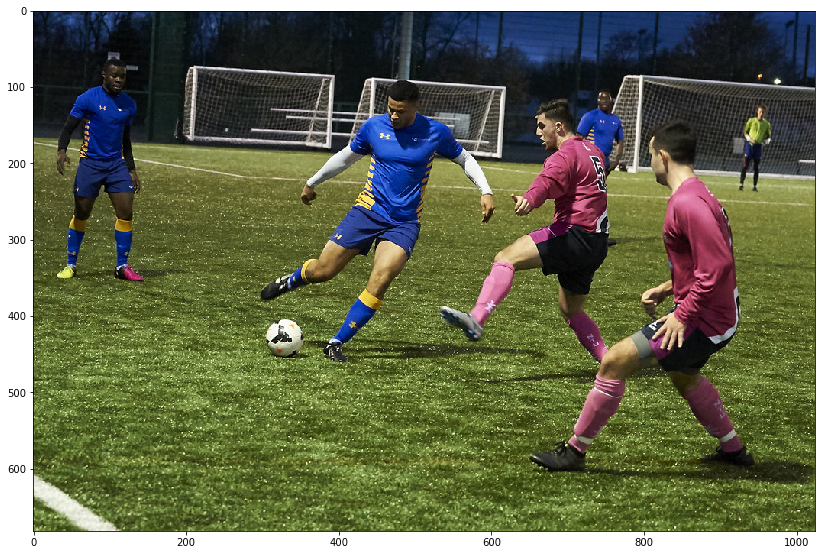

In [10]:
plt.imshow(test_output.asnumpy())
fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.show()

### 3) Transform Image

Up next, you should transform the image so it can be used as input to the pre-trained network.

Make sure you return an un-normalized version of the image that can be used for visualizations.

See the docstring for more details, but don't forget that GluonCV contains a number of utilities and helper functions to make your life easier! Check out the presets transforms.

In [11]:
from mxnet.gluon.data.vision import transforms
def transform_image(array):
    """
    Should transform image by:
    
    1) Resizing the shortest dimension to 416. e.g (832, 3328) -> (416, 1664).
    2) Cropping to a center square of dimension (416, 416).
    3) Converting the image from HWC layout to CHW layout.
    4) Normalizing the image using COCO statistics (i.e. per colour channel mean and variance).
    5) Creating a batch of 1 image.
    
    :param filepath: array (in HWC layout).
    :type filepath: mx.nd.NDArray
    
    :return: a batch of a single transformed images (in NCHW layout) and a un-normalized image.
    :rtype: tuple of (mx.nd.NDArray, numpy.ndarray)
    """
    # YOUR CODE HERE
    return data.transforms.presets.yolo.transform_test(array, short=416)

In [12]:
norm_image, unnorm_image = transform_image(test_output)
assert norm_image.shape == (1, 3, 416, 625)
assert norm_image.dtype == np.float32
assert unnorm_image.shape == (416, 625, 3)
assert unnorm_image.dtype == np.uint8

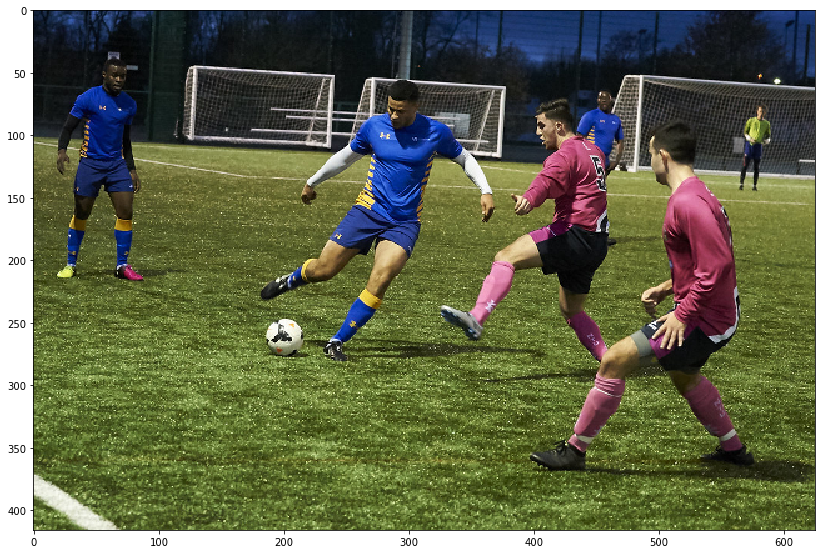

In [13]:
plt.imshow(unnorm_image)
fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.show()

### 4) Using a model

Your next task is to pass a transformed image through the network to obtain bounding box and class predictions from the network.

We'll ignore the requirement of creating just a people detector for now.

**Hint**: Don't forget that you're typically working with a batch of images, even when you only have one image.

In [14]:
def detect(network, data):
    """
    Should return the bounding boxes and class predictions from a given network and image.
    
    :param network: pre-trained object detection model
    :type network: mx.gluon.Block
    :param data: batch of transformed images of shape (1, 3, 416, 416)
    :type data: mx.nd.NDArray
    
    :return: tuple of class_ids, scores, bounding_boxes
    :rtype: tuple of mx.nd.NDArrays
    """
    # YOUR CODE HERE
    return network(data)
    return class_ids, scores, bounding_boxes

In [15]:
class_ids, scores, bounding_boxes = detect(network, norm_image)
assert class_ids.shape == (1, 100, 1)
assert scores.shape == (1, 100, 1)
assert bounding_boxes.shape == (1, 100, 4)

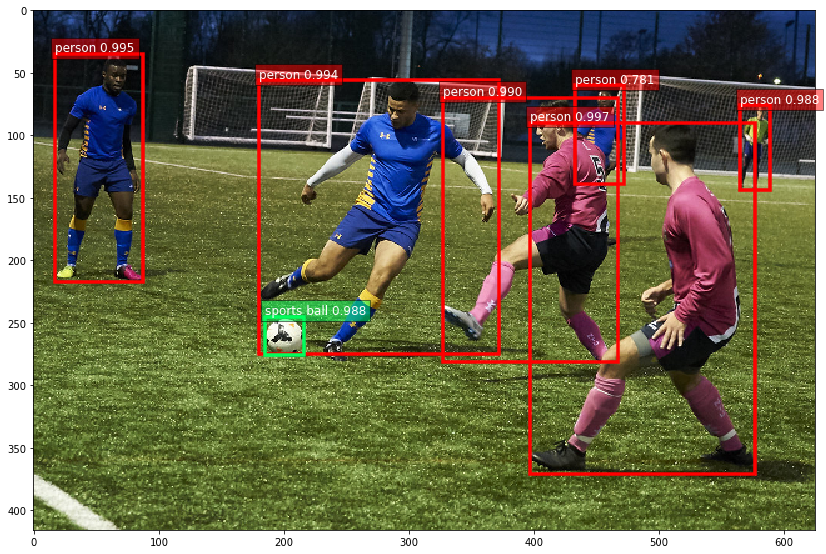

In [16]:
ax = utils.viz.plot_bbox(unnorm_image, bounding_boxes[0], scores[0], class_ids[0], class_names=network.classes)
fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.show()

We can see that the bounding boxes are placed around all the people in the image, including the goal keeper in the distance too.

Also spot that each detected object has a corresponding class label and a confidence score.

### 5) Counting Objects

In this section you should use the network outputs to determine the number of people in the image.

You'll notice that the `count_object` function has a `threshold` parameter that can control the required confidence level. When the confidence exceeds this amount for a detected person, you should add one to the total person count.

**Hint**: it's possible to use MXNet NDArray functions to do this calculations without loops.

**Hint**: All 3 network outputs are avaliable in the function (i.e. `class_ids`, `scores`, `bounding_boxes`) but only two of them are required for this task.

**Hint**: Object labels can be found on the network for pre-trained object detection models.

**Hint**: Your function should return a Python float so conversion from MXNet NDArray to Python float is required.

In [17]:
def count_object(network, class_ids, scores, bounding_boxes, object_label, threshold=0.75):
    """
    Counts objects of a given type that are predicted by the network.

    :param network: object detection network
    :type network: mx.gluon.nn.Block
    :param class_ids: predicted object class indexes (e.g. 123)
    :type class_ids: mx.nd.NDArrays
    :param scores: predicted object confidence
    :type scores: mx.nd.NDArrays
    :param bounding_boxes: predicted object locations
    :type bounding_boxes: mx.nd.NDArrays
    :param object_label: object to be counted (e.g. "person")
    :type object_label: str
    :param threshold: required confidence for object to be counted
    :type threshold: float
    
    :return: number of objects that are predicted by the network.
    :rtype: int
    """
    # YOUR CODE HERE
    detected_objects=0
    while(scores[0][detected_objects]>threshold):
        detected_objects+=1
    num_people=0
    reqd_idx = network.classes.index(object_label)
    for idx in class_ids[0][:detected_objects]:
        if (idx==reqd_idx):
            num_people+=1
    
    return num_people

In [18]:
for object_label in ["person", "sports ball"]:
    count = count_object(network, class_ids, scores, bounding_boxes, object_label)
    print("{} objects of class '{}' detected".format(count, object_label))

6 objects of class 'person' detected
1 objects of class 'sports ball' detected


In [19]:
num_people = count_object(network, class_ids, scores, bounding_boxes, "person")
assert num_people == 6

In [20]:
thresholds = [0, 0.5, 0.75, 0.9, 0.99, 0.999]
for threshold in thresholds:
    num_people = count_object(network, class_ids, scores, bounding_boxes, "person", threshold=threshold)
    print("{} people detected using a threshold of {}.".format(num_people, threshold))

6 people detected using a threshold of 0.
6 people detected using a threshold of 0.5.
6 people detected using a threshold of 0.75.
5 people detected using a threshold of 0.9.
3 people detected using a threshold of 0.99.
0 people detected using a threshold of 0.999.


You should experiment with different values for the threshold across more than a single image, but for now we'll use a threshold of 0.5.

### 6) Count People

In this section, you should stack all of the previously defined functions together and complete the implementation of the  `count` method to return the total number of people in an image. Use the `_network` and `_threshold` from `__init__`.

In [23]:
class PersonCounter():
    def __init__(self, threshold):
        self._network = gcv.model_zoo.get_model(selected_model, pretrained=True, root=M6_MODELS)
        self._threshold = threshold

    def set_threshold(self, threshold):
        self._threshold = threshold
        
    def count(self, filepath, visualize=False):
        # YOUR CODE HERE
         
        norm_image, unnorm_image = transform_image(load_image(filepath))
        class_ids, scores, bounding_boxes = network(norm_image)
        if visualize:
            self._visualize(unnorm_image, class_ids, scores, bounding_boxes)
        num_people = count_object(self._network, class_ids, scores, bounding_boxes, 'person', threshold=self._threshold)
        # YOUR CODE HERE
        
        if num_people == 1:
            print('{} person detected in {}.'.format(num_people, filepath)) 
        else:
            print('{} people detected in {}.'.format(num_people, filepath))
        return num_people
    
    def _visualize(self, unnorm_image, class_ids, scores, bounding_boxes):
        """
        Since the transformed_image is in NCHW layout and the values are normalized,
        this method slices and transposes to give CHW as required by matplotlib,
        and scales (-2, +2) to (0, 255) linearly.
        """
        ax = utils.viz.plot_bbox(unnorm_image,
                                 bounding_boxes[0],
                                 scores[0],
                                 class_ids[0],
                                 class_names=self._network.classes)
        fig = plt.gcf()
        fig.set_size_inches(14, 14)
        plt.show()

2 people detected in ../../data/module_6/images/31928213423_090ec29bcf_b.jpg.
3 people detected in ../../data/module_6/images/32701657536_8a0d9e157f_b.jpg.
4 people detected in ../../data/module_6/images/25751294956_fa3ee87fb8_b.jpg.


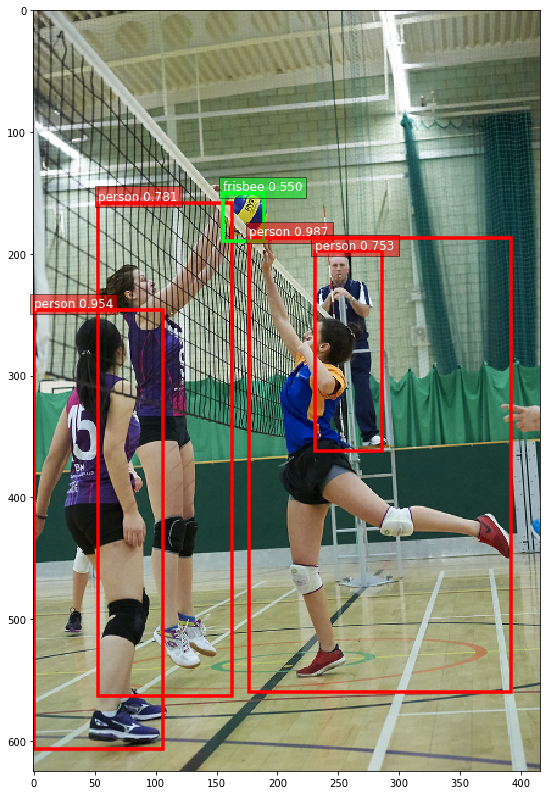

4 people detected in ../../data/module_6/images/31928213423_090ec29bcf_b.jpg.


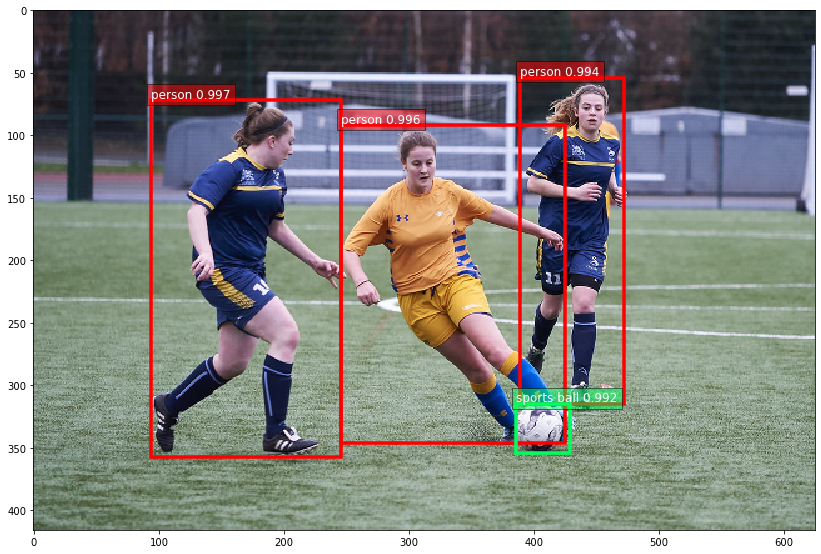

3 people detected in ../../data/module_6/images/32701657536_8a0d9e157f_b.jpg.


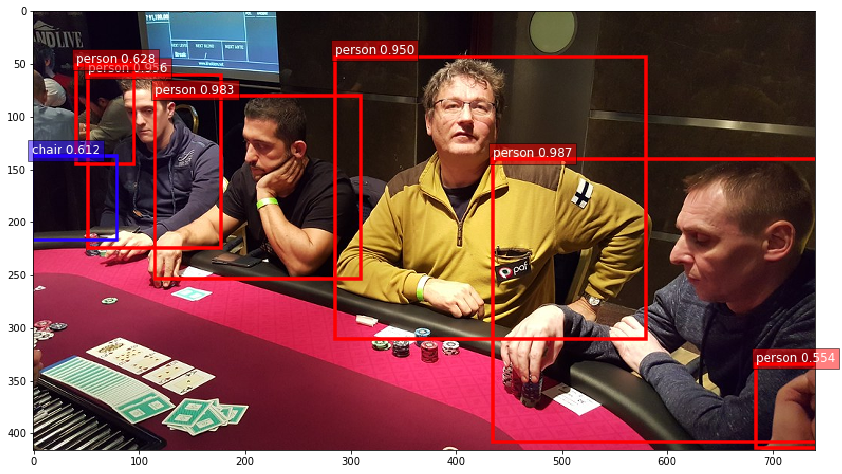

6 people detected in ../../data/module_6/images/25751294956_fa3ee87fb8_b.jpg.


In [24]:
counter = PersonCounter(threshold=0.9)
assert counter.count(Path(M6_IMAGES, '31928213423_090ec29bcf_b.jpg')) == 2
assert counter.count(Path(M6_IMAGES, '32701657536_8a0d9e157f_b.jpg')) == 3
assert counter.count(Path(M6_IMAGES, '25751294956_fa3ee87fb8_b.jpg')) == 4
counter.set_threshold(0.5)
assert counter.count(Path(M6_IMAGES, '31928213423_090ec29bcf_b.jpg'), visualize=True) == 4
assert counter.count(Path(M6_IMAGES, '32701657536_8a0d9e157f_b.jpg'), visualize=True) == 3
assert counter.count(Path(M6_IMAGES, '25751294956_fa3ee87fb8_b.jpg'), visualize=True) == 6

Although these results look good, there are still a few failure cases.

`18611133536_534285f26d_b.jpg` misses quite a few people and `3354172257_a48ba3d1d8_b.jpg` two people become one.

See if you can find more failure cases.

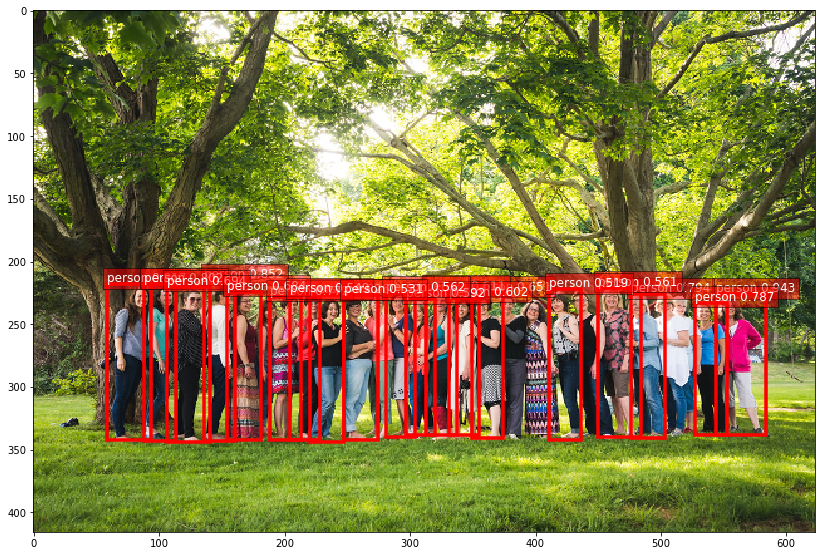

19 people detected in ../../data/module_6/images/18611133536_534285f26d_b.jpg.


19

In [25]:
counter.count(Path(M6_IMAGES, '18611133536_534285f26d_b.jpg'), visualize=True)

### 7) Count all people in a collection of images

With our person counter implemented, let's run through the whole dataset and count the number of people in our image directory.

In [26]:
total_count = 0
for filepath in M6_IMAGES.glob('**/*.jpg'):
    total_count += counter.count(filepath)
print("### Summary: {} people detected.".format(total_count))

0 people detected in ../../data/module_6/images/26795765640_2aac096e05_b.jpg.
4 people detected in ../../data/module_6/images/3263304224_621f36f98b.jpg.
4 people detected in ../../data/module_6/images/31928213423_090ec29bcf_b.jpg.
1 person detected in ../../data/module_6/images/29756013612_0018b057d8_b.jpg.
1 person detected in ../../data/module_6/images/29869572955_0b59d43c55_z.jpg.
19 people detected in ../../data/module_6/images/18611133536_534285f26d_b.jpg.
0 people detected in ../../data/module_6/images/14920793105_74c19b981f_z.jpg.
3 people detected in ../../data/module_6/images/32701657536_8a0d9e157f_b.jpg.
4 people detected in ../../data/module_6/images/3354172257_a48ba3d1d8_b.jpg.
3 people detected in ../../data/module_6/images/47764429062_8c19a19cd1_b.jpg.
1 person detected in ../../data/module_6/images/36949889492_c946a8bddc_z.jpg.
1 person detected in ../../data/module_6/images/14986165665_00d6b5ea1b_z.jpg.
2 people detected in ../../data/module_6/images/2455110397_757dfec3

## Summary & Congratulations!

In this final assignment of the course, you used a pre-trained object detection model to count people in a dataset of images.

Although we are not eliminating false positives, the model was able to identify over 70 people in the dataset.

You've now completed Computer Vision with GluonCV from AWS. We hope to see you in the next course.